In [1]:
using BlockBandedMatrices, BandedMatrices, ArrayLayouts, FillArrays, LazyBandedMatrices, LazyArrays
using Plots

In [2]:
function ftest(x, y)
    amp = 1.0
    beta = 2.0
    sigma = 5.0
    nx = length(x)
    ny = length(y)
    f = Array{Float64,2}(undef,nx,ny)
    dxf = similar(f)
    dyf = similar(f)
    for j=1:ny
        for i = 1:nx
            f[i,j] = amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*sin(beta*x[i])
            dxf[i,j] = amp*beta*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*cos(beta*x[i]) - (4.0*amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*x[i]*sin(beta*x[i]))/sigma
            dyf[i,j] = (-2.0*amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*y[j]*sin(beta*x[i]))/sigma
        end
    end
    return f, dxf, dyf
end

ftest (generic function with 1 method)

In [3]:
function dP6(n, h)
    
    #A = BandedMatrix{Float64}(undef, (n,n), (2,2))
    A = BandedMatrix(Ones(n,n), (2,2))
    alpha = 17.0/57.0
    beta = -1.0/114.0
    A[band(1)] .= alpha
    A[band(2)] .= beta
    A[band(-1)] .= alpha
    A[band(-2)] .= beta
    A[1,2] = 8.0
    A[1,3] = 6.0
    A[n,n-2] = 6.0
    A[n,n-1] = 8.0

    B = BandedMatrix(Zeros(n,n), (5,5))
    hm1 = 1.0/h
    a = 30.0/19.0
    t1 = a*(0.5*hm1)
    B[band(-1)]  .= -t1
    B[band(1)] .= t1
    
    a = -43.0/12.0*hm1
    b = -20.0/3.0*hm1
    c = 9.0*hm1
    d = 4.0/3.0*hm1
    e = -1.0/12.0*hm1
    
    B[1,1] = a
    B[1,2] = b
    B[1,3] = c
    B[1,4] = d
    B[1,5] = e

    B[n,n-4] = -e
    B[n,n-3] = -d
    B[n,n-2] = -c
    B[n,n-1] = -b
    B[n,n] = -a
    
    return A, B
end

dP6 (generic function with 1 method)

In [4]:
nx = 41
ny = 21
x1 = LinRange(-2.0, 2.0, nx)
y1 = LinRange(-1.0, 1.0, ny)
fe, dxfe, dyfe = ftest(x1, y1)
hx = x1[2] - x1[1]
hy = y1[2] - y1[1]

0.10000000000000009

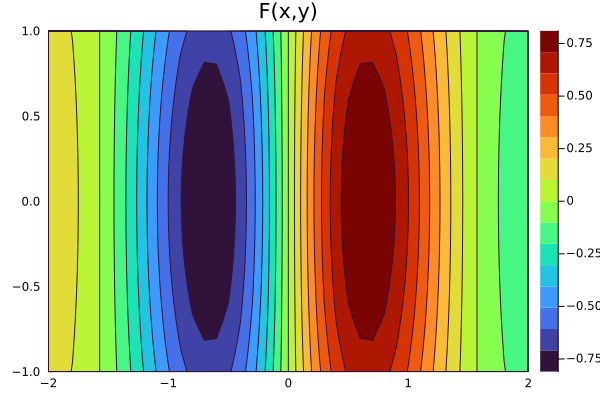

In [5]:
#heatmap(f1)
contour(x1, y1, fe',fill=true, color=:turbo, title="F(x,y)")

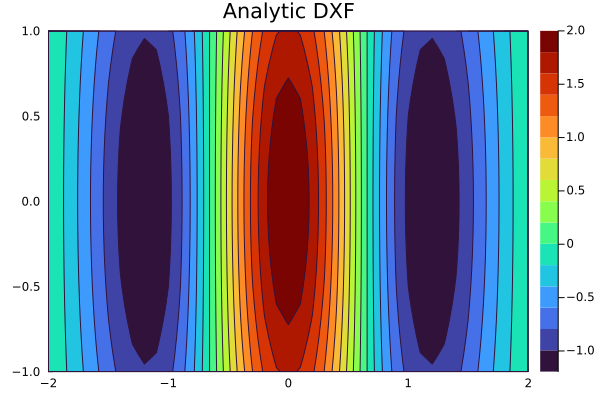

In [6]:
contour(x1, y1, dxfe',fill=true, color=:turbo, title="Analytic DXF")

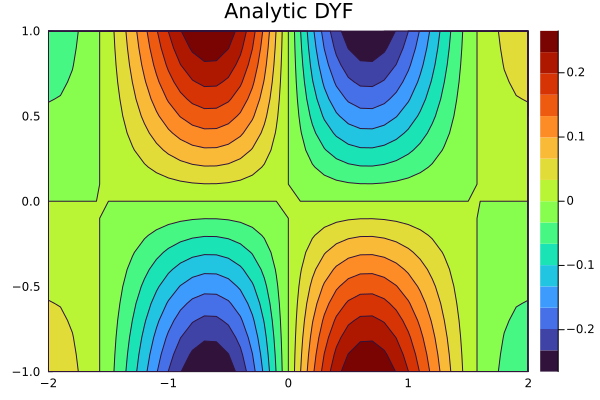

In [7]:
contour(x1, y1, dyfe',fill=true, color=:turbo, title="Analytic DYF")

In [8]:
Ap6x, Bp6x = dP6(nx, hx)
Dp6x = Ap6x \ Bp6x;

In [9]:
Ap6y, Bp6y = dP6(ny, hy)
Dp6y = Ap6y \ Bp6y;

In [10]:
Dp6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), Dp6x))
Dp6y_2d = BandedBlockBandedMatrix(Kron(Dp6y, Eye(nx)));

In [11]:
f1d = vec(fe)
dxf1d = Dp6x_2d*f1d;
dyf1d = Dp6y_2d*f1d;

In [12]:
dxf = reshape(dxf1d,nx,ny);
dyf = reshape(dyf1d,nx,ny);

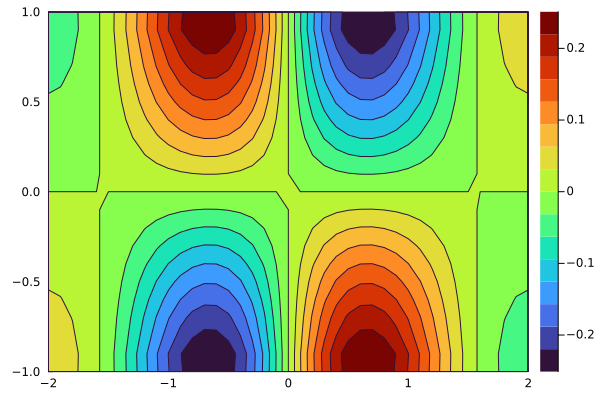

In [13]:
contour(x1, y1, dyf', fill=true, color=:turbo)

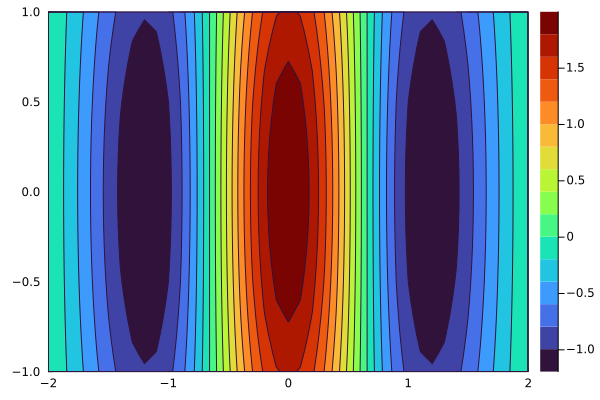

In [14]:
contour(x1, y1, dxf', fill=true, color=:turbo)

In [15]:
ww = Array{Int64,2}(undef,5,5)
for j = 1:5
    for i = 1:5
        ww[i,j] = (i-1) + 10*(j-1)
    end
end

In [16]:
px = zeros(5,5)
for i = 1:5
    k = i+1 
    if k<6; px[i,k] = 0.5 end
    k = i-1
    if k > 0; px[i,k] = -0.5 end
end
px[1,1] = -1.0
px[1,2] = 1.0
px[5,4] = -1.0
px[5,5] = 1.0
ident = zeros(5,5)
for i = 1:5
    ident[i,i] = 1.0
end
px

5×5 Matrix{Float64}:
 -1.0   1.0   0.0   0.0  0.0
 -0.5   0.0   0.5   0.0  0.0
  0.0  -0.5   0.0   0.5  0.0
  0.0   0.0  -0.5   0.0  0.5
  0.0   0.0   0.0  -1.0  1.0

In [17]:
include("kim.jl")

filterT8 (generic function with 1 method)

In [18]:
Px, Qx = derivKim4(nx,hx)
Dk6x = Px \ Qx;
Py, Qy = derivKim4(ny,hy)
Dk6y = Py \ Qy;

In [19]:
Pfx, Qfx = filterKim6(nx)
Pfy, Qfy = filterKim6(ny)
F6x = Pfx \ Qfx
F6y = Pfy \ Qfy;

In [20]:
Dk6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), Dk6x))
Dk6y_2d = BandedBlockBandedMatrix(Kron(Dk6y, Eye(nx)));

In [21]:
dkxf1d = Dk6x_2d*f1d;
dkyf1d = Dk6y_2d*f1d;

In [22]:
dkxf = reshape(dkxf1d,nx,ny);
dkyf = reshape(dkyf1d,nx,ny);

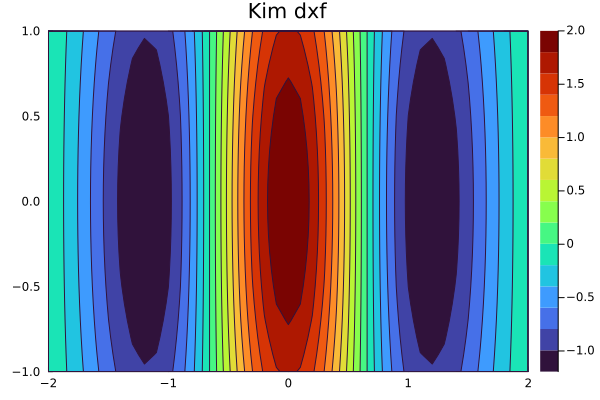

In [23]:
contour(x1, y1, dkxf', fill=true, color=:turbo, title="Kim dxf")

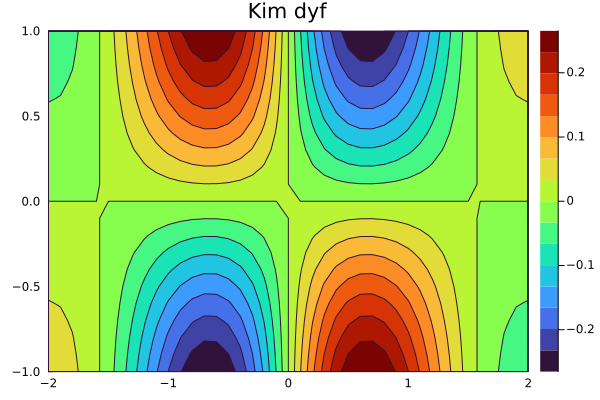

In [24]:
contour(x1, y1, dkyf', fill=true, color=:turbo, title="Kim dyf")

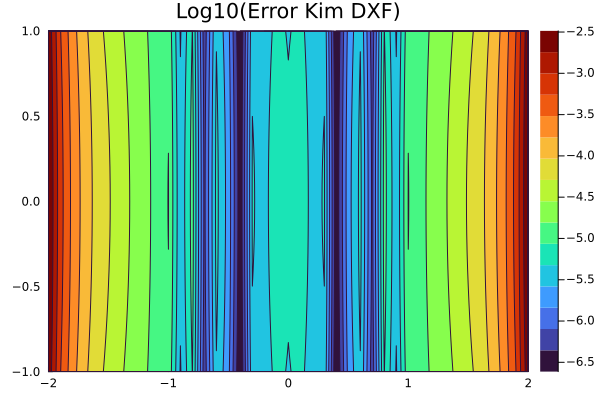

In [25]:
dkxferr = similar(dkxf)
@. dkxferr = log10(abs(dkxf - dxfe))
contour(x1, y1, dkxferr', fill=true, color=:turbo, title="Log10(Error Kim DXF)")

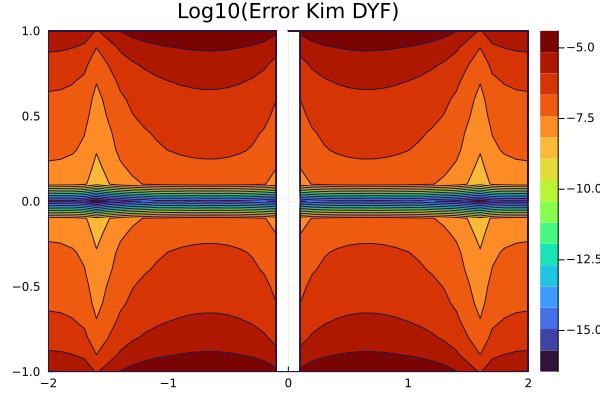

In [26]:
dkyferr = similar(dkyf)
@. dkyferr = log10(abs(dkyf - dyfe))
contour(x1, y1, dkyferr', fill=true, color=:turbo, title="Log10(Error Kim DYF)")

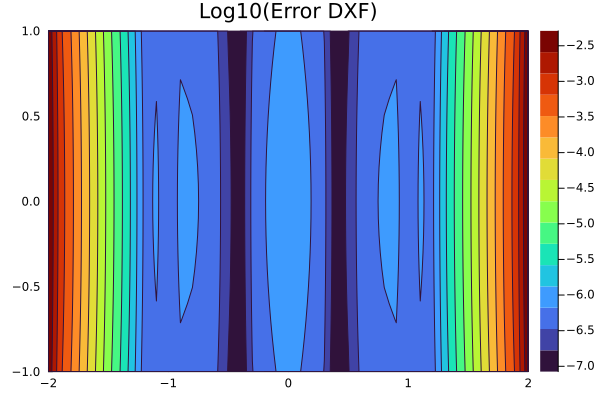

In [27]:
dxferr = similar(dxf)
@. dxferr = log10(abs(dxf - dxfe))
contour(x1, y1, dxferr', fill=true, color=:turbo, title="Log10(Error DXF)")

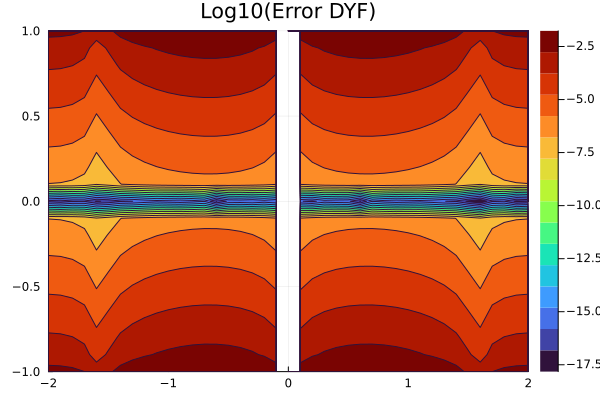

In [28]:
dyferr = similar(dyf)
@. dyferr = log10(abs(dyf - dyfe))
contour(x1, y1, dyferr', fill=true, color=:turbo, title="Log10(Error DYF)")

In [29]:
Sx, Tx = derivBLT6(nx,hx)
L6x = Sx \ Tx;
Sy, Ty = derivBLT6(ny,hy)
L6y = Sy \ Ty;

In [30]:
L6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), L6x))
L6y_2d = BandedBlockBandedMatrix(Kron(L6y, Eye(nx)));

In [31]:
dlxf1d = L6x_2d*f1d;
dlyf1d = L6y_2d*f1d;

In [32]:
dlxf = reshape(dlxf1d,nx,ny);
dlyf = reshape(dlyf1d,nx,ny);

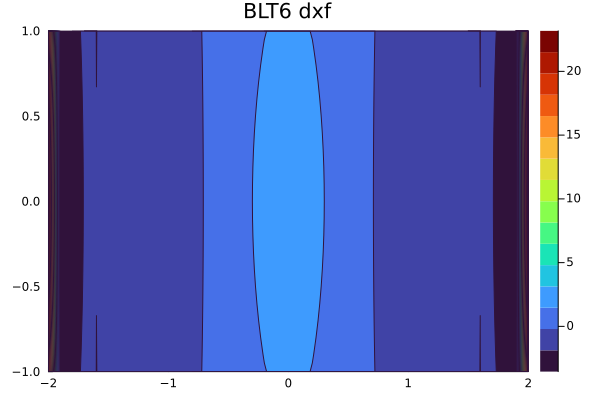

In [33]:
contour(x1, y1, dlxf', fill=true, color=:turbo, title="BLT6 dxf")

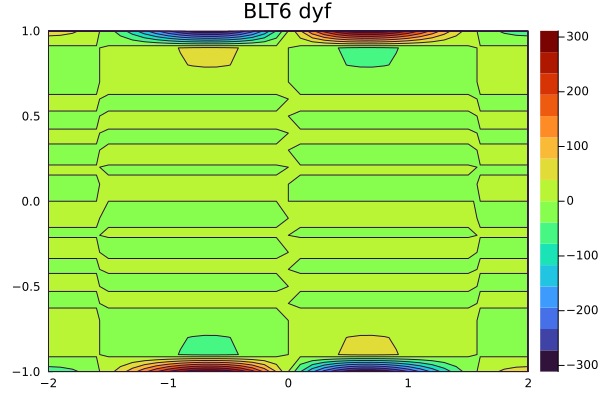

In [34]:
contour(x1, y1, dlyf', fill=true, color=:turbo, title="BLT6 dyf")

In [35]:
Sx, Tx = derivBLT6(11,hx)

([1.0 6.85667616635778 … 0.0 0.0; 0.41230047387468755 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.41230047387468755; 0.0 0.0 … 6.85667616635778 1.0], [-36.54668566604886 -24.280658468875927 … 0.0 0.0; -10.43602511743192 0.0 … 0.0 0.0; … ; 0.0 0.0 … -0.0 10.43602511743192; 0.0 0.0 … 24.280658468875927 36.54668566604886])

In [36]:
Sx

11×11 BandedMatrix{Float64} with bandwidths (1, 1):
 1.0      6.85668     ⋅          ⋅        …    ⋅          ⋅         ⋅ 
 0.4123   1.0        1.95634     ⋅             ⋅          ⋅         ⋅ 
  ⋅      -0.479872   1.0       -1.29308        ⋅          ⋅         ⋅ 
  ⋅        ⋅        -0.391778   1.0            ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅         0.333333       ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅        …    ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅             ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅           -0.391778    ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅            1.0       -0.479872   ⋅ 
  ⋅        ⋅          ⋅          ⋅            1.95634    1.0       0.4123
  ⋅        ⋅          ⋅          ⋅        …    ⋅         6.85668   1.0

In [37]:
Tx

11×11 BandedMatrix{Float64} with bandwidths (5, 5):
 -36.5467    -24.2807   87.1335    …     ⋅          ⋅         ⋅ 
 -10.436       0.0      -7.13615         ⋅          ⋅         ⋅ 
   1.89077    -3.03408   0.0             ⋅          ⋅         ⋅ 
  -0.543833    4.5563   -8.9863         0.0         ⋅         ⋅ 
   0.0         0.0      -0.277778       0.0        0.0        ⋅ 
   0.0         0.0       0.0       …    0.0        0.0       0.0
    ⋅          0.0       0.0            0.277778   0.0       0.0
    ⋅           ⋅        0.0            8.9863    -4.5563    0.543833
    ⋅           ⋅         ⋅            -0.0        3.03408  -1.89077
    ⋅           ⋅         ⋅             7.13615   -0.0      10.436
    ⋅           ⋅         ⋅        …  -87.1335    24.2807   36.5467

In [38]:
Px, Qx = derivKim4(11,hx)

([1.0 5.912678614078549 … 0.0 0.0; 0.08360703307833438 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.08360703307833438; 0.0 0.0 … 5.912678614078549 1.0], [-32.4068156347249 -34.56878182643606 … 0.0 0.0; -3.177447290722618 -14.68827048894461 … 0.0 0.0; … ; 0.0 0.0 … 14.68827048894461 3.177447290722618; 0.0 0.0 … 34.56878182643606 32.4068156347249])

In [39]:
Px

11×11 BandedMatrix{Float64} with bandwidths (2, 2):
 1.0        5.91268    3.77562    …   ⋅          ⋅          ⋅ 
 0.083607   1.0        2.0581         ⋅          ⋅          ⋅ 
 0.0325001  0.399804   1.0            ⋅          ⋅          ⋅ 
  ⋅         0.0954953  0.58627        ⋅          ⋅          ⋅ 
  ⋅          ⋅         0.0954953      ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.0954953   ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.58627    0.0954953   ⋅ 
  ⋅          ⋅          ⋅            1.0        0.399804   0.0325001
  ⋅          ⋅          ⋅            2.0581     1.0        0.083607
  ⋅          ⋅          ⋅         …  3.77562    5.91268    1.0

In [40]:
Qx

11×11 BandedMatrix{Float64} with bandwidths (6, 6):
 -32.4068     -34.5688     58.3904     …     ⋅           ⋅           ⋅ 
  -3.17745    -14.6883     -0.280763         ⋅           ⋅           ⋅ 
  -1.21901     -6.30165    -3.1196          0.0          ⋅           ⋅ 
  -0.0714095   -2.58601    -6.43141         0.0         0.0          ⋅ 
   0.0         -0.0714095  -2.58601         0.0         0.0         0.0
   0.0          0.0        -0.0714095  …    0.0714095   0.0         0.0
   0.0          0.0         0.0             2.58601     0.0714095   0.0
    ⋅           0.0         0.0             6.43141     2.58601     0.0714095
    ⋅            ⋅          0.0             3.1196      6.30165     1.21901
    ⋅            ⋅           ⋅              0.280763   14.6883      3.17745
    ⋅            ⋅           ⋅         …  -58.3904     34.5688     32.4068

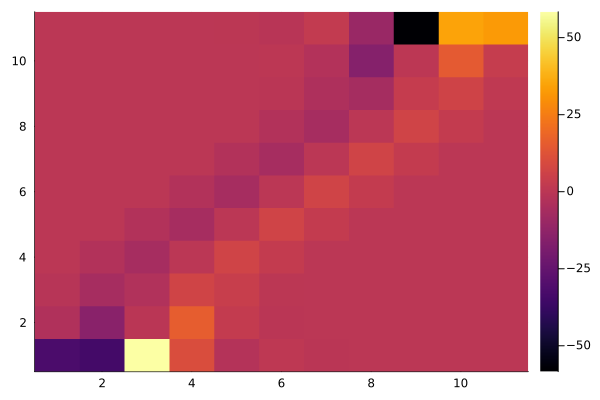

In [41]:
heatmap(Qx)

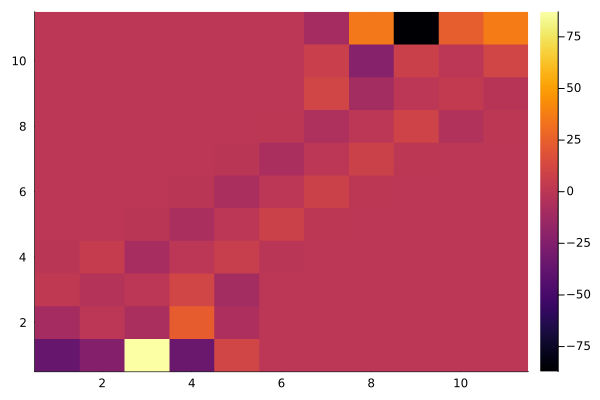

In [42]:
heatmap(Tx)

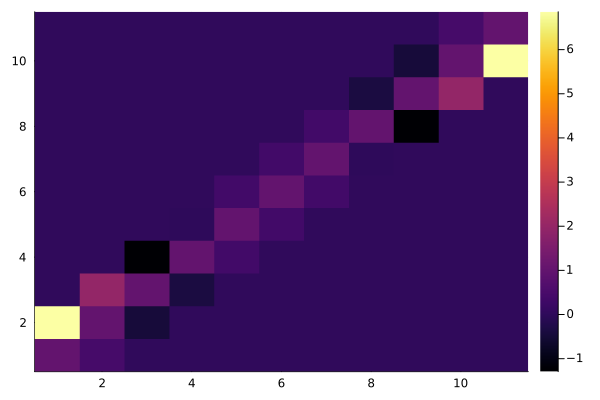

In [43]:
heatmap(Sx')

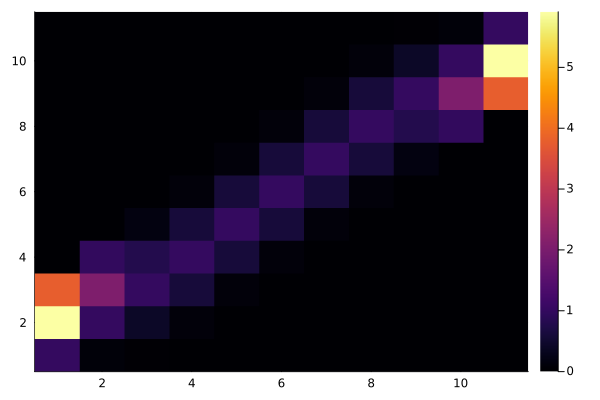

In [44]:
heatmap(Px')

In [45]:
q1 = similar(x1)
@. q1 = sin(x1)


41-element Vector{Float64}:
 -0.9092974268256817
 -0.9463000876874145
 -0.9738476308781953
 -0.9916648104524686
 -0.9995736030415051
 -0.9974949866040544
 -0.9854497299884601
 -0.963558185417193
 -0.9320390859672264
 -0.8912073600614354
 -0.8414709848078965
 -0.7833269096274833
 -0.7173560908995227
  ⋮
  0.7833269096274833
  0.8414709848078965
  0.8912073600614354
  0.9320390859672264
  0.963558185417193
  0.9854497299884601
  0.9974949866040544
  0.9995736030415051
  0.9916648104524686
  0.9738476308781953
  0.9463000876874145
  0.9092974268256817

In [46]:
dkq = Dk6x*q1
dLq = L6x*q1

41-element Vector{Float64}:
 402.8718908124359
 -59.34792315283853
 -54.551630648178985
 -21.177008752780775
   8.01048382368702
  -3.0001485777425168
   1.3429411349743028
  -0.18053736859172764
   0.533492353415188
   0.3882285209643151
   0.5652705072343264
   0.6120729633480068
   0.7003495212701608
   ⋮
   0.6120729633480071
   0.5652705072343255
   0.388228520964315
   0.5334923534151857
  -0.1805373685917291
   1.3429411349743026
  -3.000148577742506
   8.010483823686997
 -21.177008752780708
 -54.55163064817881
 -59.34792315283834
 402.8718908124345

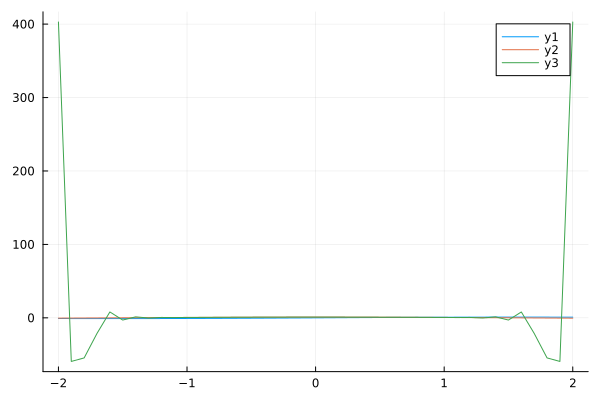

In [47]:
plot(x1,q1)
plot!(x1,dkq)
plot!(x1,dLq)
#plot!(x1,dLq,xrange=(-1,1),yrange=(-1.2,1.2))

In [48]:
typeof(Dk6x_2d)

BandedBlockBandedMatrix{Float64, BlockArrays.PseudoBlockMatrix{Float64, Matrix{Float64}, Tuple{BlockArrays.BlockedUnitRange{StepRange{Int64, Int64}}, Base.OneTo{Int64}}}, Base.OneTo{Int64}}